In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install efficientnet-3D keras_applications

     |████████████████████████████████| 50 kB 506 kB/s eta 0:00:01


In [35]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import cv2
import time
import glob
import os
from tensorflow.keras import layers
import efficientnet_3D.tfkeras as efn

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,csv_path='/kaggle/input/rsnasubmissionresult/result.csv',width=256,height=256,batch_size=16,shuffle=True):
        self.df = pd.read_csv(csv_path,dtype='str')
        self.batch_size = batch_size
        self.base_dir = '/kaggle/input/classify-tumor/DATATUMORONLY/train'
        self.width = width
        self.crop_length = 224
        self.height = height
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return int(len(self.df)/self.batch_size)
    
    def __getitem__(self,index):
        start =time.time()
        batch = self.df[index*self.batch_size:(index+1)*self.batch_size]
        self.max_depth = self.get_max_len(batch, min_depth=1)
        #print(self.max_depth)
        batch_x = self.__data_gen_batch(batch)
        print('time taken:',(time.time()-start)*1000)
        return batch_x/255.0,self.one_hot_encoder(list(batch['MGMT_value'].astype(int)))
    
    def one_hot_encoder(self,y):
        b = np.zeros((len(y), 2))
        b[np.arange(len(y)),y] = 1
        return b
    
    def get_max_len(self,batch,min_depth=50):
        max_len = 0
        for patient_id in batch['folder_id']:
            #print(os.path.join(self.base_dir,patient_id,'flair/*'))
            length = len(glob.glob(os.path.join(self.base_dir,patient_id,'flair/*')))
            if length > max_len:
                max_len = length
        if max_len < min_depth:
            max_len = min_depth
        return max_len
    
    def __data_gen_image(self,folder_name):
        flair_path = glob.glob(os.path.join(self.base_dir,folder_name,'flair/*'))
        all_images = []
        all_images = np.zeros(shape=(self.max_depth,self.height,self.width,1),dtype=np.float64)
        for i,img_path in enumerate(flair_path):
            img = image.load_img(img_path,target_size=(self.height,self.width),color_mode='grayscale')
            img = image.img_to_array(img)
            #img = self.crop(img)
            all_images[i,] = img
        return np.transpose(all_images,(1,2,0,3))

    def __data_gen_batch(self,batch):
        batch_data = np.empty(shape=(self.batch_size,self.height,self.width,self.max_depth,1))
        for i,patient_id in enumerate(batch['folder_id']):
            batch_data[i,] = self.__data_gen_image(patient_id)
        return batch_data
    
    def crop(self,image):
        img_height ,img_width = image.shape[:2]
        start_y = (img_height - self.crop_length) // 2
        start_x = (img_width - self.crop_length) // 2
        cropped_image=image[start_y:(img_height - start_y), start_x:(img_width - start_x), :]
        return cropped_image

In [37]:
IW,IH = 224,224
datagen = DataGenerator(batch_size=3,height=IH,width=IW)

(3, 224, 224, 36, 1)
7 0.0 1.0


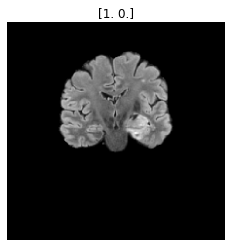

20 0.0 0.0


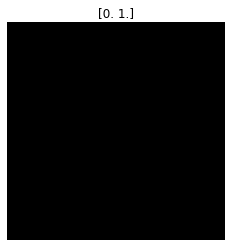

34 0.0 0.0


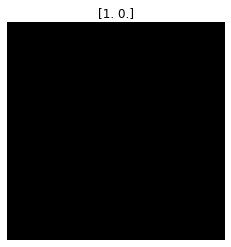

In [40]:
x,y = datagen[0]
print(x.shape)
for i in range(x.shape[0]):
    if i>5:
        break
    stacknum = np.random.randint(0,x.shape[3])
    print(stacknum,np.min(x[i][:,:,stacknum,0]),np.max(x[i][:,:,stacknum,0]))
    imgsample = x[i][:,:,stacknum,0]
    plt.title(str(y[i]))
    plt.axis('off')
    plt.imshow(imgsample, cmap='gray')
    plt.show()

In [ ]:
def get_model(width=256, height=256, depth=None):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))
    x = layers.Conv3D(filters=32, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=128, activation="relu")(x)
    #x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=2, activation="softmax")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model

model = get_model(width=IW, height=IH, depth=None)
model.summary()
Model: "3dcnn"

In [41]:
basemodel = efn.EfficientNetB0(input_shape=(IW, IH, None, 1), weights=None)
x = layers.GlobalAveragePooling3D()(basemodel.output)
x = layers.Dense(units=128, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(units=2, activation="softmax")(x)
# Define the model.
model = keras.Model(basemodel.input, outputs, name="eff3dcnn")
model.summary()

Model: "eff3dcnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, No 0                                            
__________________________________________________________________________________________________
stem_conv (Conv3D)              (None, 112, 112, Non 864         input_5[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, Non 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, Non 0           stem_bn[0][0]                    
___________________________________________________________________________________________

In [42]:
basemodel.output,basemodel.input,model.output,model.input

(<KerasTensor: shape=(None, 7, 7, None, 1280) dtype=float32 (created by layer 'top_activation')>,
 <KerasTensor: shape=(None, 224, 224, None, 1) dtype=float32 (created by layer 'input_5')>,
 <KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'dense_5')>,
 <KerasTensor: shape=(None, 224, 224, None, 1) dtype=float32 (created by layer 'input_5')>)

In [43]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True,metrics="accuracy",mode=max
)

In [46]:
model.fit_generator(
    datagen,
    steps_per_epoch=len(datagen),
    epochs=10,
    verbose=0,
    callbacks=[checkpoint_cb],
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


KeyboardInterrupt: 

In [26]:
o = np.zeros((3,224,224,1,1))
out = model(o)

In [27]:
out.shape

TensorShape([3, 2])